🚀 PRODUCTION FINANCIAL SENTIMENT ANALYZER - DEMO

Features Enabled:
  ✓ Hybrid AI Engine (FinBERT + Lexicon)
  ✓ Financial Ratio Extraction
  ✓ Trend Detection
  ✓ Confidence Scoring
  ✓ Clarity Index
  ✓ Visual Dashboards
  ✓ Export Capabilities (JSON/CSV)


📥 Loading FinBERT model...
✅ FinBERT loaded on cpu

🔍 Analyzing Solstice Technologies, Inc. - Quarterly Report (10-Q)
📊 Extracting financial ratios...
📝 Calculating clarity index...
🤖 Running hybrid sentiment analysis...
   - Analyzing Revenue & Growth...
   - Analyzing Profitability...
   - Analyzing Liquidity & Solvency...
   - Analyzing Operational Efficiency...
   - Analyzing Future Outlook...
💡 Generating insights...
✅ Analysis complete!

COMPREHENSIVE FINANCIAL SENTIMENT ANALYSIS REPORT

Company: Solstice Technologies, Inc.
Document Type: Quarterly Report (10-Q)
Analysis Date: 2025-10-31 18:52:08

EXECUTIVE SUMMARY

Solstice Technologies, Inc. faces challenges requiring strategic attention. Strength in Future Outlook (Neutra

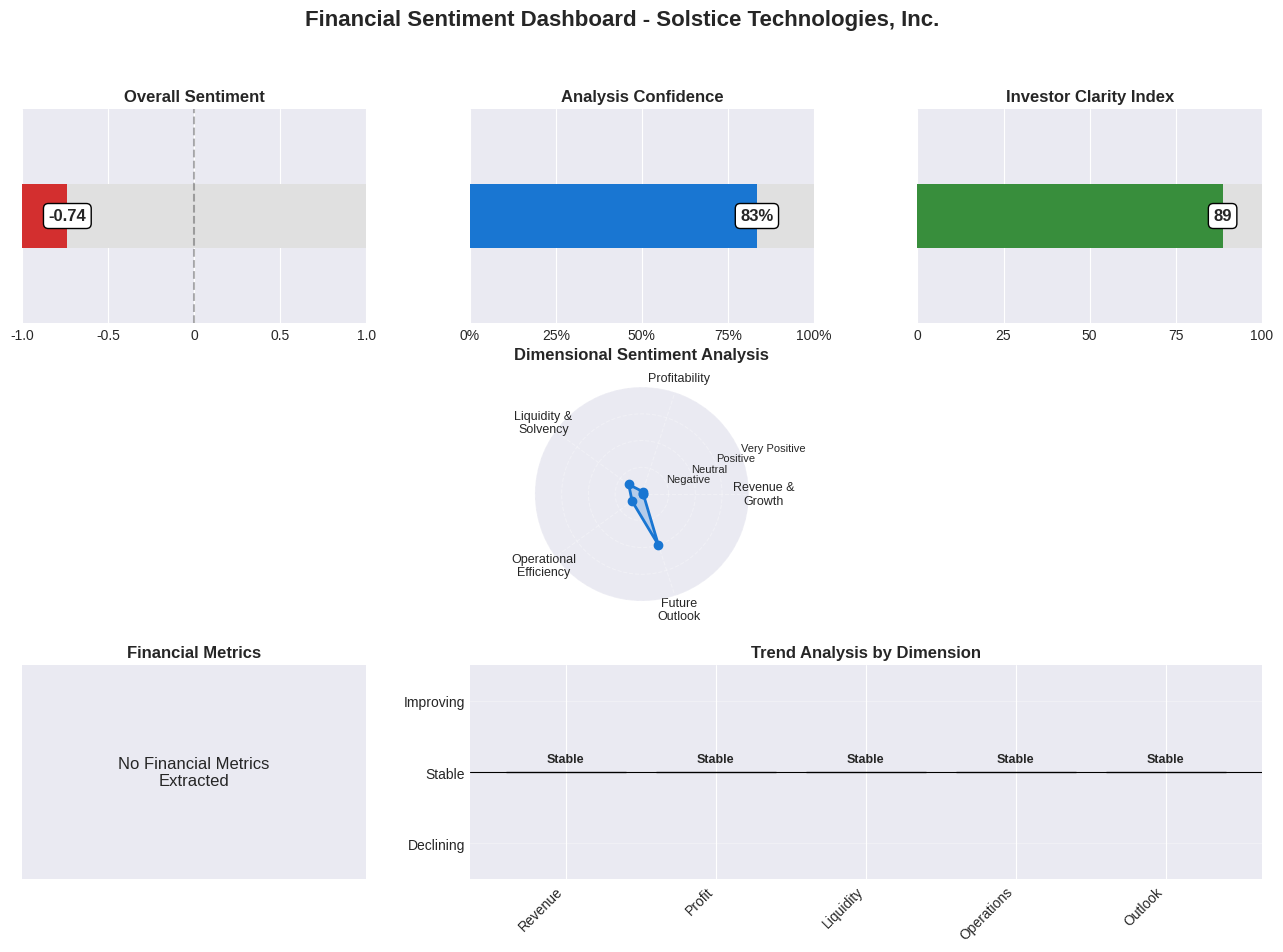

In [ ]:
import re
import json
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# graphs that are helpful during analysis
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOTTING_AVAILABLE = True
except ImportError:
    PLOTTING_AVAILABLE = False
    print("Install matplotlib & seaborn for visualizations: pip install matplotlib seaborn")

# transformer models
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Install transformers: pip install transformers torch")


@dataclass
class FinancialMetrics:
    """Financial ratios and metrics extracted from document"""
    revenue_growth: Optional[float] = None
    profit_margin: Optional[float] = None
    debt_to_equity: Optional[float] = None
    current_ratio: Optional[float] = None
    roe: Optional[float] = None
    eps_growth: Optional[float] = None

    def to_dict(self):
        return {k: v for k, v in asdict(self).items() if v is not None}


@dataclass
class SentimentAnalysis:
    """Comprehensive sentiment analysis result"""
    dimension: str # varied possibilities of investment strats
    sentiment: str  # Positive/Neutral/Negative
    score: float  # -1 to 1
    confidence: float  # 0 to 1
    trend: str  # Improving/Stable/Declining
    evidence: List[str]
    reasoning: str

    def to_dict(self):
        return asdict(self)


@dataclass
class ComprehensiveReport:
    """Complete analysis report"""
    company_name: str
    document_type: str
    analysis_date: str
    overall_sentiment: str
    overall_score: float
    confidence_score: float
    clarity_index: float

    # financial dimensions
    revenue_analysis: SentimentAnalysis
    profitability_analysis: SentimentAnalysis
    liquidity_analysis: SentimentAnalysis
    operational_analysis: SentimentAnalysis
    outlook_analysis: SentimentAnalysis

    # Financial metrics
    financial_metrics: FinancialMetrics

    # Insights
    key_strengths: List[str]
    key_risks: List[str]
    investment_recommendation: str
    executive_summary: str
    comparative_context: Optional[Dict] = None

    def to_dict(self):
        result = asdict(self)
        return result


class FinBERTAnalyzer:
    """FinBERT-based sentiment analyzer for financial text"""

    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.device = None

        if TRANSFORMERS_AVAILABLE:
            try:
                print("📥 Loading FinBERT model...")
                self.tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
                self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
                self.device = "cuda" if torch.cuda.is_available() else "cpu"
                self.model.to(self.device)
                self.model.eval()
                print(f"✅ FinBERT loaded on {self.device}")
            except Exception as e:
                print(f"⚠️ FinBERT loading failed: {e}")
                self.model = None

    def analyze_sentiment(self, text: str) -> Tuple[float, float, str]:
        """
        Analyze sentiment using FinBERT
        Returns: (score, confidence, label)
        """
        if not self.model or not text.strip():
            return 0.0, 0.0, "neutral"

        try:
            # Tokenize and predict
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True,
                                   max_length=512, padding=True).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                probs = probs.cpu().numpy()[0]

            # FinBERT will give these following outputs: [positive, negative, neutral]
            labels = ['positive', 'negative', 'neutral']
            label_idx = np.argmax(probs)
            confidence = float(probs[label_idx])

            # conversion in sigmoid score between -1 to 1
            if labels[label_idx] == 'positive':
                score = probs[0] - probs[1]
            elif labels[label_idx] == 'negative':
                score = -(probs[1] - probs[0])
            else:
                score = 0.0

            return float(score), confidence, labels[label_idx]

        except Exception as e:
            print(f"⚠️ FinBERT analysis error: {e}")
            return 0.0, 0.0, "neutral"


class FinancialRatioExtractor:
    """Extract financial ratios and metrics from text"""

    def __init__(self):
        self.ratio_patterns = {
            'revenue_growth': r'revenue.{0,30}(?:grew|increased|growth).{0,20}(\d+(?:\.\d+)?)\s*%',
            'profit_margin': r'(?:profit|operating|net)\s+margin.{0,20}(\d+(?:\.\d+)?)\s*%',
            'debt_to_equity': r'debt.{0,20}equity.{0,20}(?:ratio|of).{0,20}(\d+(?:\.\d+)?)',
            'current_ratio': r'current\s+ratio.{0,20}(\d+(?:\.\d+)?)',
            'roe': r'(?:ROE|return\s+on\s+equity).{0,20}(\d+(?:\.\d+)?)\s*%',
            'eps_growth': r'EPS.{0,30}(?:grew|increased|growth).{0,20}(\d+(?:\.\d+)?)\s*%'
        }

    def extract_metrics(self, text: str) -> FinancialMetrics:
        """Extract financial ratios from document text"""
        text_lower = text.lower()
        metrics = FinancialMetrics()

        for metric_name, pattern in self.ratio_patterns.items():
            matches = re.findall(pattern, text_lower)
            if matches:
                try:
                    value = float(matches[0])
                    setattr(metrics, metric_name, value)
                except ValueError:
                    continue

        return metrics


class HybridSentimentEngine:
    """
    Hybrid sentiment engine combining:
    - FinBERT transformer model
    - Rule-based lexicon analysis
    - Financial ratio interpretation
    - Trend detection
    """

    def __init__(self, use_finbert: bool = True):
        self.finbert = FinBERTAnalyzer() if use_finbert and TRANSFORMERS_AVAILABLE else None
        self.ratio_extractor = FinancialRatioExtractor()

        # yahoo finance-like lexicons
        self.positive_lexicon = {
            'strong', 'robust', 'growth', 'increase', 'improved', 'positive',
            'excellent', 'momentum', 'solid', 'outperform', 'exceed', 'accelerate',
            'expansion', 'optimize', 'strengthen', 'enhance', 'successful',
            'profitable', 'gain', 'achieve', 'milestone', 'opportunity',
            'confident', 'bullish', 'upward', 'record', 'outstanding',
            'innovative', 'competitive', 'diversified', 'resilient', 'sustainable'
        }

        self.negative_lexicon = {
            'decline', 'decrease', 'weak', 'challenge', 'difficult', 'loss',
            'risk', 'concern', 'pressure', 'uncertainty', 'volatility', 'adverse',
            'deteriorate', 'struggle', 'underperform', 'miss', 'shortfall',
            'impairment', 'negative', 'downturn', 'unfavorable', 'slowdown',
            'headwind', 'cautious', 'bearish', 'deficit', 'constraint',
            'disruption', 'threat', 'vulnerable', 'unstable', 'crisis'
        }

        self.trend_indicators = {
            'improving': ['improved', 'improving', 'better', 'increased', 'strengthen', 'recovery'],
            'declining': ['declined', 'declining', 'worse', 'decreased', 'weaken', 'deteriorat']
        }

    def calculate_clarity_index(self, text: str) -> float:
        """
        Calculate investor clarity index (0-100)
        Measures how clear and transparent the communication is
        """
        sentences = [s.strip() for s in re.split(r'[.!?]', text) if len(s.strip()) > 10]

        if not sentences:
            return 50.0

        # Factors affecting clarity
        avg_sentence_length = np.mean([len(s.split()) for s in sentences])

        # Penalty for overly complex sentences
        complexity_penalty = max(0, (avg_sentence_length - 20) * 2)

        # Count of hedge words (reduces clarity)
        hedge_words = {'may', 'might', 'could', 'possibly', 'potential', 'uncertain'}
        hedge_count = sum(1 for s in sentences for w in s.lower().split() if w in hedge_words)
        hedge_penalty = (hedge_count / len(sentences)) * 20

        # Count of specific numbers (increases clarity)
        number_count = len(re.findall(r'\d+(?:\.\d+)?%?', text))
        specificity_bonus = min(20, number_count * 0.5)

        # Base clarity score
        clarity = 70 - complexity_penalty - hedge_penalty + specificity_bonus

        return np.clip(clarity, 0, 100)

    def detect_trend(self, text: str) -> str:
        """Detect if sentiment is improving, declining, or stable"""
        text_lower = text.lower()

        improving_score = sum(1 for word in self.trend_indicators['improving'] if word in text_lower)
        declining_score = sum(1 for word in self.trend_indicators['declining'] if word in text_lower)

        if improving_score > declining_score + 1:
            return "Improving"
        elif declining_score > improving_score + 1:
            return "Declining"
        else:
            return "Stable"

    def analyze_dimension(self, text: str, dimension: str,
                         keywords: List[str]) -> SentimentAnalysis:
        """
        Analyze sentiment for a specific financial dimension
        Uses hybrid approach: FinBERT + lexicon + context
        """
        # Extract relevant sentences
        sentences = [s.strip() for s in re.split(r'[.!?]', text) if len(s.strip()) > 20]
        relevant_sentences = []

        for sentence in sentences:
            sentence_lower = sentence.lower()
            if any(kw in sentence_lower for kw in keywords):
                relevant_sentences.append(sentence)

        if not relevant_sentences:
            return SentimentAnalysis(
                dimension=dimension,
                sentiment="Neutral",
                score=0.0,
                confidence=0.0,
                trend="Stable",
                evidence=["Insufficient data in document"],
                reasoning="No relevant information found for this dimension."
            )

        # Combine text for analysis
        combined_text = ' '.join(relevant_sentences[:10])  # Top 10 relevant sentences

        # Method 1: FinBERT analysis (if available)
        finbert_score, finbert_conf = 0.0, 0.0
        if self.finbert:
            finbert_score, finbert_conf, _ = self.finbert.analyze_sentiment(combined_text)

        # Method 2: Lexicon-based analysis
        words = set(re.findall(r'\b\w+\b', combined_text.lower()))
        pos_count = len(words & self.positive_lexicon)
        neg_count = len(words & self.negative_lexicon)

        if pos_count + neg_count > 0:
            lexicon_score = (pos_count - neg_count) / (pos_count + neg_count)
        else:
            lexicon_score = 0.0

        # Hybrid fusion: weighted average
        if self.finbert:
            final_score = 0.7 * finbert_score + 0.3 * lexicon_score
            confidence = finbert_conf * 0.8 + 0.2
        else:
            final_score = lexicon_score
            confidence = 0.6 if (pos_count + neg_count) > 3 else 0.4

        # Classify sentiment
        if final_score > 0.2:
            sentiment = "Positive"
        elif final_score < -0.2:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"

        # Detect trend
        trend = self.detect_trend(combined_text)

        # Generate reasoning
        reasoning = self._generate_reasoning(dimension, sentiment, final_score,
                                            pos_count, neg_count, trend)

        # Select best evidence sentences
        evidence = relevant_sentences[:3]

        return SentimentAnalysis(
            dimension=dimension,
            sentiment=sentiment,
            score=round(float(final_score), 3),
            confidence=round(float(confidence), 3),
            trend=trend,
            evidence=evidence,
            reasoning=reasoning
        )

    def _generate_reasoning(self, dimension: str, sentiment: str,
                           score: float, pos_count: int, neg_count: int,
                           trend: str) -> str:
        """Generate explainable reasoning for sentiment"""
        reasoning = f"The {dimension} dimension shows {sentiment.lower()} sentiment "
        reasoning += f"(score: {score:.2f}) based on "

        if pos_count > neg_count:
            reasoning += f"{pos_count} positive indicators vs {neg_count} negative indicators. "
        elif neg_count > pos_count:
            reasoning += f"{neg_count} negative indicators vs {pos_count} positive indicators. "
        else:
            reasoning += "balanced positive and negative signals. "

        reasoning += f"The trend appears to be {trend.lower()}."

        return reasoning


class ProductionSentimentAnalyzer:
    """
    Production-grade Financial Sentiment Analyzer
    Enterprise-ready with all advanced features
    """

    def __init__(self, use_finbert: bool = True,
                 anthropic_api_key: Optional[str] = None):
        self.engine = HybridSentimentEngine(use_finbert=use_finbert)
        self.ratio_extractor = FinancialRatioExtractor()
        self.anthropic_client = None


        # Financial dimension keywords
        self.dimensions = {
            'Revenue & Growth': ['revenue', 'sales', 'income', 'earnings', 'growth rate', 'top line', 'market share'],
            'Profitability': ['profit', 'margin', 'ebitda', 'operating income', 'net income', 'bottom line', 'profitability'],
            'Liquidity & Solvency': ['cash', 'liquidity', 'working capital', 'debt', 'leverage', 'solvency', 'balance sheet'],
            'Operational Efficiency': ['efficiency', 'productivity', 'operations', 'cost', 'expenses', 'utilization', 'optimization'],
            'Future Outlook': ['outlook', 'guidance', 'forecast', 'expect', 'anticipate', 'future', 'plan', 'strategy']
        }

    def extract_metadata(self, text: str) -> Tuple[str, str]:
        """Extract company name and document type"""
        company_patterns = [
            r'(?:^|\n)([A-Z][A-Za-z\s&]+(?:Inc\.|Corp\.|LLC|Limited|Corporation))',
            r'Company:\s*([A-Z][A-Za-z\s&]+)',
        ]
        # company name detection
        company_name = "Unknown Company"
        for pattern in company_patterns:
            match = re.search(pattern, text[:1000])
            if match:
                company_name = match.group(1).strip()
                break

        # doc type detection
        text_lower = text.lower()[:1000]
        if '10-k' in text_lower or 'annual report' in text_lower:
            doc_type = "Annual Report (10-K)"
        elif '10-q' in text_lower or 'quarterly report' in text_lower:
            doc_type = "Quarterly Report (10-Q)"
        elif 'earnings call' in text_lower:
            doc_type = "Earnings Call Transcript"
        else:
            doc_type = "Financial Document"

        return company_name, doc_type

    def _generate_investment_recommendation(self, overall_score: float,
                                           confidence: float,
                                           analyses: Dict[str, SentimentAnalysis],
                                           metrics: FinancialMetrics) -> str:
        """Generate investment recommendation with reasoning"""

        # Count positive dimensions
        positive_dims = sum(1 for a in analyses.values() if a.sentiment == "Positive")
        negative_dims = sum(1 for a in analyses.values() if a.sentiment == "Negative")

        # Check for strong metrics
        strong_metrics = []
        if metrics.revenue_growth and metrics.revenue_growth > 10:
            strong_metrics.append("strong revenue growth")
        if metrics.profit_margin and metrics.profit_margin > 15:
            strong_metrics.append("healthy profit margins")
        if metrics.debt_to_equity and metrics.debt_to_equity < 0.5:
            strong_metrics.append("low leverage")

        # Generate recommendation
        if overall_score > 0.3 and confidence > 0.7:
            rec = " **BUY** - Strong positive sentiment with high confidence. "
            rec += f"{positive_dims} of 5 dimensions show positive trends. "
            if strong_metrics:
                rec += f"Supported by {', '.join(strong_metrics)}."
        elif overall_score > 0.1 and confidence > 0.6:
            rec = " **HOLD/ACCUMULATE** - Moderately positive with stable fundamentals. "
            rec += "Consider for long-term portfolio allocation."
        elif overall_score < -0.2:
            rec = " **SELL/AVOID** - Negative sentiment detected. "
            rec += f"{negative_dims} dimensions show concerning trends. "
            rec += "Exercise caution or consider exit strategies."
        else:
            rec = " **HOLD** - Mixed signals. "
            rec += "Monitor closely for clearer directional signals."

        return rec

    def _extract_strengths_and_risks(self, analyses: Dict[str, SentimentAnalysis]) -> Tuple[List[str], List[str]]:
        """Extract key strengths and risks from dimensional analyses"""
        strengths = []
        risks = []

        for dim_name, analysis in analyses.items():
            if analysis.sentiment == "Positive" and analysis.score > 0.3:
                strengths.append(f"{dim_name}: {analysis.reasoning}")
            elif analysis.sentiment == "Negative" and analysis.score < -0.2:
                risks.append(f"{dim_name}: {analysis.reasoning}")

        return strengths[:3], risks[:3]  # Top 3 each

    def _generate_executive_summary(self, company: str, overall_score: float,
                                   analyses: Dict[str, SentimentAnalysis],
                                   metrics: FinancialMetrics) -> str:
        """Generate concise executive summary"""

        if overall_score > 0.3:
            tone = "demonstrates strong financial performance and positive momentum"
        elif overall_score > 0:
            tone = "shows stable performance with room for improvement"
        else:
            tone = "faces challenges requiring strategic attention"

        summary = f"{company} {tone}. "

        # only highlight the best dimension
        best_dim = max(analyses.items(), key=lambda x: x[1].score)
        summary += f"Strength in {best_dim[0]} ({best_dim[1].sentiment}, {best_dim[1].trend} trend). "

        # Note any metrics
        if metrics.revenue_growth:
            summary += f"Revenue growth at {metrics.revenue_growth:.1f}%. "

        return summary

    def analyze(self, document_text: str,
                company_name: Optional[str] = None,
                comparative_data: Optional[Dict] = None) -> ComprehensiveReport:
        """
        Perform comprehensive sentiment analysis

        Args:
            document_text: Full financial document text
            company_name: Optional company name override
            comparative_data: Optional dict with peer/historical data

        Returns:
            ComprehensiveReport with full analysis
        """

        # Extract metadata
        if not company_name:
            company_name, doc_type = self.extract_metadata(document_text)
        else:
            _, doc_type = self.extract_metadata(document_text)

        print(f"\n🔍 Analyzing {company_name} - {doc_type}")

        # Extract financial metrics
        print("📊 Extracting financial ratios...")
        financial_metrics = self.ratio_extractor.extract_metrics(document_text)

        # Calculate clarity index
        print("📝 Calculating clarity index...")
        clarity = self.engine.calculate_clarity_index(document_text)

        # Analyze each dimension
        print("🤖 Running hybrid sentiment analysis...")
        analyses = {}
        for dim_name, keywords in self.dimensions.items():
            print(f"   - Analyzing {dim_name}...")
            analyses[dim_name] = self.engine.analyze_dimension(
                document_text, dim_name, keywords
            )

        # Calculate overall sentiment (weighted)
        weights = {
            'Revenue & Growth': 0.25,
            'Profitability': 0.25,
            'Liquidity & Solvency': 0.20,
            'Operational Efficiency': 0.15,
            'Future Outlook': 0.15
        }

        overall_score = sum(analyses[dim].score * weights[dim] for dim in analyses)
        overall_confidence = np.mean([a.confidence for a in analyses.values()])

        # Classify overall sentiment
        if overall_score > 0.2:
            overall_sentiment = "Positive"
        elif overall_score < -0.2:
            overall_sentiment = "Negative"
        else:
            overall_sentiment = "Neutral"

        # Generate insights
        print("💡 Generating insights...")
        strengths, risks = self._extract_strengths_and_risks(analyses)
        recommendation = self._generate_investment_recommendation(
            overall_score, overall_confidence, analyses, financial_metrics
        )
        executive_summary = self._generate_executive_summary(
            company_name, overall_score, analyses, financial_metrics
        )

        # Create comprehensive report
        report = ComprehensiveReport(
            company_name=company_name,
            document_type=doc_type,
            analysis_date=datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            overall_sentiment=overall_sentiment,
            overall_score=round(float(overall_score), 3),
            confidence_score=round(float(overall_confidence), 3),
            clarity_index=round(float(clarity), 1),
            revenue_analysis=analyses['Revenue & Growth'],
            profitability_analysis=analyses['Profitability'],
            liquidity_analysis=analyses['Liquidity & Solvency'],
            operational_analysis=analyses['Operational Efficiency'],
            outlook_analysis=analyses['Future Outlook'],
            financial_metrics=financial_metrics,
            key_strengths=strengths,
            key_risks=risks,
            investment_recommendation=recommendation,
            executive_summary=executive_summary,
            comparative_context=comparative_data
        )

        print("✅ Analysis complete!")
        return report

    def generate_visual_dashboard(self, report: ComprehensiveReport,
                                  save_path: Optional[str] = None):
        """Generate visual dashboard with charts"""

        if not PLOTTING_AVAILABLE:
            print("⚠️ Plotting libraries not available. Install matplotlib and seaborn.")
            return

        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Overall sentiment gauge
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_sentiment_gauge(ax1, report.overall_score, "Overall Sentiment")

        # Confidence meter
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_confidence_meter(ax2, report.confidence_score)

        # Clarity index
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_clarity_index(ax3, report.clarity_index)

        # Dimensional sentiment radar
        ax4 = fig.add_subplot(gs[1, :], projection='polar')
        self._plot_sentiment_radar(ax4, report)

        # Financial metrics
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_financial_metrics(ax5, report.financial_metrics)

        # Trend analysis
        ax6 = fig.add_subplot(gs[2, 1:])
        self._plot_trend_analysis(ax6, report)

        plt.suptitle(f"Financial Sentiment Dashboard - {report.company_name}",
                    fontsize=16, fontweight='bold', y=0.98)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Dashboard saved to {save_path}")

        plt.tight_layout()
        plt.show()

    def _plot_sentiment_gauge(self, ax, score, title):
        """Plot sentiment gauge"""
        colors = ['#d32f2f', '#f57c00', '#fbc02d', '#7cb342', '#388e3c']
        score_norm = (score + 1) / 2  # Normalize to 0-1

        ax.barh([0], [1], color='#e0e0e0', height=0.3)
        ax.barh([0], [score_norm], color=colors[int(score_norm * 4)], height=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels(['-1.0', '-0.5', '0', '0.5', '1.0'])
        ax.set_yticks([])
        ax.set_title(title, fontweight='bold')
        ax.axvline(0.5, color='black', linestyle='--', alpha=0.3)
        ax.text(score_norm, 0, f'{score:.2f}', ha='center', va='center',
               fontweight='bold', fontsize=12, bbox=dict(boxstyle='round',
               facecolor='white', edgecolor='black'))

    def _plot_confidence_meter(self, ax, confidence):
        """Plot confidence meter"""
        ax.barh([0], [1], color='#e0e0e0', height=0.3)
        ax.barh([0], [confidence], color='#1976d2', height=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
        ax.set_yticks([])
        ax.set_title('Analysis Confidence', fontweight='bold')
        ax.text(confidence, 0, f'{confidence*100:.0f}%', ha='center', va='center',
               fontweight='bold', fontsize=12, bbox=dict(boxstyle='round',
               facecolor='white', edgecolor='black'))

    def _plot_clarity_index(self, ax, clarity):
        """Plot clarity index"""
        color = '#388e3c' if clarity > 70 else '#f57c00' if clarity > 50 else '#d32f2f'
        ax.barh([0], [100], color='#e0e0e0', height=0.3)
        ax.barh([0], [clarity], color=color, height=0.3)
        ax.set_xlim(0, 100)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_yticks([])
        ax.set_title('Investor Clarity Index', fontweight='bold')
        ax.text(clarity, 0, f'{clarity:.0f}', ha='center', va='center',
               fontweight='bold', fontsize=12, bbox=dict(boxstyle='round',
               facecolor='white', edgecolor='black'))

    def _plot_sentiment_radar(self, ax, report):
        """Plot radar chart of dimensional sentiments"""
        dimensions = ['Revenue &\nGrowth', 'Profitability', 'Liquidity &\nSolvency',
                     'Operational\nEfficiency', 'Future\nOutlook']
        scores = [
            report.revenue_analysis.score,
            report.profitability_analysis.score,
            report.liquidity_analysis.score,
            report.operational_analysis.score,
            report.outlook_analysis.score
        ]

        # Normalize to 0-1 for plotting
        scores_norm = [(s + 1) / 2 for s in scores]
        scores_norm += scores_norm[:1]  # Close the polygon

        angles = np.linspace(0, 2 * np.pi, len(dimensions), endpoint=False).tolist()
        angles += angles[:1]

        ax.plot(angles, scores_norm, 'o-', linewidth=2, color='#1976d2', label='Sentiment')
        ax.fill(angles, scores_norm, alpha=0.25, color='#1976d2')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(dimensions, size=9)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels(['Negative', 'Neutral', 'Positive', 'Very Positive'], size=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_title('Dimensional Sentiment Analysis', fontweight='bold', pad=20)

    def _plot_financial_metrics(self, ax, metrics: FinancialMetrics):
        """Plot financial metrics as bar chart"""
        metrics_dict = metrics.to_dict()

        if not metrics_dict:
            ax.text(0.5, 0.5, 'No Financial Metrics\nExtracted',
                   ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Financial Metrics', fontweight='bold')
            return

        names = [k.replace('_', ' ').title() for k in metrics_dict.keys()]
        values = list(metrics_dict.values())

        colors = ['#388e3c' if v > 10 else '#f57c00' if v > 0 else '#d32f2f'
                 for v in values]

        bars = ax.barh(names, values, color=colors, alpha=0.7)
        ax.set_xlabel('Value (%)', fontweight='bold')
        ax.set_title('Financial Metrics', fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

        for i, (bar, val) in enumerate(zip(bars, values)):
            ax.text(val, i, f' {val:.1f}%', va='center', fontweight='bold')

    def _plot_trend_analysis(self, ax, report):
        """Plot trend analysis"""
        dimensions = ['Revenue', 'Profit', 'Liquidity', 'Operations', 'Outlook']
        analyses = [
            report.revenue_analysis,
            report.profitability_analysis,
            report.liquidity_analysis,
            report.operational_analysis,
            report.outlook_analysis
        ]

        trend_map = {'Improving': 1, 'Stable': 0, 'Declining': -1}
        trend_values = [trend_map[a.trend] for a in analyses]
        colors = ['#388e3c' if t > 0 else '#fbc02d' if t == 0 else '#d32f2f'
                 for t in trend_values]

        x = np.arange(len(dimensions))
        bars = ax.bar(x, trend_values, color=colors, alpha=0.7, edgecolor='black')

        ax.set_xticks(x)
        ax.set_xticklabels(dimensions, rotation=45, ha='right')
        ax.set_ylim(-1.5, 1.5)
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels(['Declining', 'Stable', 'Improving'])
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
        ax.set_title('Trend Analysis by Dimension', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        for i, (bar, trend) in enumerate(zip(bars, [a.trend for a in analyses])):
            ax.text(i, trend_values[i] + 0.1 * np.sign(trend_values[i] or 1),
                   trend, ha='center', va='bottom' if trend_values[i] >= 0 else 'top',
                   fontweight='bold', fontsize=9)

    # reports will be generated in this specific format (change according to the docs.)
    def generate_text_report(self, report: ComprehensiveReport) -> str:
        """Generate formatted text report"""

        border = "=" * 80
        section = "-" * 80

        output = f"""
{border}
COMPREHENSIVE FINANCIAL SENTIMENT ANALYSIS REPORT
{border}

Company: {report.company_name}
Document Type: {report.document_type}
Analysis Date: {report.analysis_date}

{border}
EXECUTIVE SUMMARY
{border}

{report.executive_summary}

Overall Sentiment: {report.overall_sentiment} ({report.overall_score:+.3f})
Confidence Score: {report.confidence_score:.1%}
Investor Clarity Index: {report.clarity_index:.1f}/100

{border}
INVESTMENT RECOMMENDATION
{border}

{report.investment_recommendation}

{border}
DIMENSIONAL ANALYSIS
{border}

REVENUE & GROWTH
{section}
Sentiment: {report.revenue_analysis.sentiment} (Score: {report.revenue_analysis.score:+.3f})
Confidence: {report.revenue_analysis.confidence:.1%}
Trend: {report.revenue_analysis.trend}
Reasoning: {report.revenue_analysis.reasoning}

Evidence:
"""
        for i, ev in enumerate(report.revenue_analysis.evidence[:2], 1):
            output += f"  [{i}] {ev}\n"

        output += f"""
PROFITABILITY
{section}
Sentiment: {report.profitability_analysis.sentiment} (Score: {report.profitability_analysis.score:+.3f})
Confidence: {report.profitability_analysis.confidence:.1%}
Trend: {report.profitability_analysis.trend}
Reasoning: {report.profitability_analysis.reasoning}

Evidence:
"""
        for i, ev in enumerate(report.profitability_analysis.evidence[:2], 1):
            output += f"  [{i}] {ev}\n"

        output += f"""
LIQUIDITY & SOLVENCY
{section}
Sentiment: {report.liquidity_analysis.sentiment} (Score: {report.liquidity_analysis.score:+.3f})
Confidence: {report.liquidity_analysis.confidence:.1%}
Trend: {report.liquidity_analysis.trend}
Reasoning: {report.liquidity_analysis.reasoning}

OPERATIONAL EFFICIENCY
{section}
Sentiment: {report.operational_analysis.sentiment} (Score: {report.operational_analysis.score:+.3f})
Confidence: {report.operational_analysis.confidence:.1%}
Trend: {report.operational_analysis.trend}
Reasoning: {report.operational_analysis.reasoning}

FUTURE OUTLOOK
{section}
Sentiment: {report.outlook_analysis.sentiment} (Score: {report.outlook_analysis.score:+.3f})
Confidence: {report.outlook_analysis.confidence:.1%}
Trend: {report.outlook_analysis.trend}
Reasoning: {report.outlook_analysis.reasoning}

Evidence:
"""
        for i, ev in enumerate(report.outlook_analysis.evidence[:2], 1):
            output += f"  [{i}] {ev}\n"

        # Financial metrics
        metrics = report.financial_metrics.to_dict()
        if metrics:
            output += f"""
{border}
FINANCIAL METRICS
{border}
"""
            for metric, value in metrics.items():
                output += f"  • {metric.replace('_', ' ').title()}: {value:.1f}%\n"

        # Key insights
        output += f"""
{border}
KEY STRENGTHS
{border}
"""
        for i, strength in enumerate(report.key_strengths, 1):
            output += f"  ✅ {strength}\n"

        if not report.key_strengths:
            output += "  No significant strengths identified.\n"

        output += f"""
{border}
KEY RISKS
{border}
"""
        for i, risk in enumerate(report.key_risks, 1):
            output += f"  ⚠️ {risk}\n"

        if not report.key_risks:
            output += "  No significant risks identified.\n"

        output += f"""
{border}
END OF REPORT
{border}

Generated by Yug's Financial Sentiment Analyzer
Hybrid Model: FinBERT + Rule-Based + Financial Ratio Analysis
"""

        return output

    def export_to_json(self, report: ComprehensiveReport, filepath: str):
        """Export report to JSON"""
        report_dict = report.to_dict()

        with open(filepath, 'w') as f:
            json.dump(report_dict, f, indent=2)

        print(f"✅ Report exported to {filepath}")

    def export_to_csv(self, report: ComprehensiveReport, filepath: str):
        """Export dimensional analysis to CSV"""
        data = {
            'Dimension': [],
            'Sentiment': [],
            'Score': [],
            'Confidence': [],
            'Trend': []
        }

        analyses = [
            ('Revenue & Growth', report.revenue_analysis),
            ('Profitability', report.profitability_analysis),
            ('Liquidity & Solvency', report.liquidity_analysis),
            ('Operational Efficiency', report.operational_analysis),
            ('Future Outlook', report.outlook_analysis)
        ]

        for dim_name, analysis in analyses:
            data['Dimension'].append(dim_name)
            data['Sentiment'].append(analysis.sentiment)
            data['Score'].append(analysis.score)
            data['Confidence'].append(analysis.confidence)
            data['Trend'].append(analysis.trend)

        df = pd.DataFrame(data)
        df.to_csv(filepath, index=False)

        print(f"✅ CSV exported to {filepath}")


# functions for downstream use cases
def quick_analyze(document_text: str, company_name: str = None,
                 use_finbert: bool = True, show_dashboard: bool = True) -> ComprehensiveReport:
    """
    Quick analysis function for easy use in notebooks

    Args:
        document_text: Financial document text
        company_name: Optional company name
        use_finbert: Whether to use FinBERT (requires transformers)
        show_dashboard: Whether to display visual dashboard

    Returns:
        ComprehensiveReport object
    """
    analyzer = ProductionSentimentAnalyzer(use_finbert=use_finbert)
    report = analyzer.analyze(document_text, company_name)

    # Print text report
    print(analyzer.generate_text_report(report))

    # Show dashboard
    if show_dashboard and PLOTTING_AVAILABLE:
        analyzer.generate_visual_dashboard(report)

    return report


# Example usage
if __name__ == "__main__":
    # Sample financial document
    sample_doc = """
    Quarterly Report — Q3 2025

Company: Solstice Technologies, Inc.
Period: Quarter ended September 30, 2025
Currency: USD (millions, except per-share figures)

Executive summary

During Q3 2025 Solstice Technologies experienced headwinds across top-line and operating performance. Revenue declined versus both the prior quarter and year-ago period. Gross margin compression and higher operating expenses translated into an operating loss for the quarter. Management has initiated a set of cash-preservation and operational-prioritization measures while revising near-term expectations.

Key financials (Q3 2025)
Metric	Q3 2025	Q2 2025	Q3 2024	% QoQ	% YoY
Revenue	215.4	263.0	263.2	-18.1%	-18.1%
Gross profit	48.3	73.9	76.5	-34.6%	-36.9%
Gross margin	22.4%	28.1%	29.1%	-570 bps	-670 bps
Operating income (loss)	(17.8)	4.6	6.2	n.m.	n.m.
Net income (loss)	(24.5)	(2.1)	1.9	n.m.	n.m.
EPS — diluted	(0.18)	(0.02)	0.01	n.m.	n.m.
Adjusted EBITDA	2.3	22.0	24.8	-89.6%	-90.7%
Cash & equivalents	41.2	69.8	95.5	-41.0%	-56.9%
Free cash flow	(21.7)	(4.8)	12.4	n.m.	n.m.

n.m. = not meaningful. Figures rounded to one decimal.

Revenue and demand trends

Product revenue decreased 20% YoY, driven by lower order volumes in both Americas and EMEA.

Services and recurring revenue declined 9% YoY; contract renewals showed slower uptake and average contract value contracted.

Bookings for the quarter were down materially; backlog decreased by 28% compared with Q3 2024.

Management attributes part of the decline to elongated sales cycles and subdued enterprise spending in the sector.

Margins and cost structure

Gross margin compressed due to a combination of lower factory utilization, higher component costs (notably semiconductors), and unfavorable product mix.

Operating expenses remained elevated as certain strategic R&D initiatives continued; selling & marketing spend was reduced sequentially but not enough to offset margin pressure.

Adjusted operating leverage was negative for the quarter.

Cash flow & liquidity

Cash balance declined to $41.2M at quarter-end after funding working capital needs and one-time restructuring-related payments.

Operating cash flow was negative; free cash flow outflow primarily driven by inventory buildup and receivable collection timing.

Short-term liquidity includes a $50M revolving facility (undrawn at quarter-end) and a $10M government incentive receivable.

Management states they are prioritizing cash conservation and will defer non-essential capital projects.

Operational highlights

Inventory days increased to 116 days (vs. 78 days in Q3 2024), reflecting slower shipment velocity and supplier minimum order commitments.

Headcounts were reduced by ~8% in the quarter through a targeted workforce realignment; savings will be phased in over the next two quarters.

A facility consolidation plan was announced; expected one-time charges of $6–8M to be recognized in Q4 2025.

Product roadmap remains unchanged, but time-to-market for certain modules has been extended.

Balance sheet items of note

Accounts receivable days rose to 72 days from 58 days a year ago.

Inventory write-down of $4.1M recorded this quarter due to product obsolescence in a legacy line.

No changes to capital lease obligations; no new equity or debt issuances during the quarter.

Management commentary (selected excerpts)

“We are prioritizing stability and liquidity while we work through a period of reduced demand. Actions taken this quarter — from realigning our cost base to deferring select capital projects — are intended to preserve optionality and protect runway.”
“Our focus remains on converting our pipeline and accelerating collections; near-term results will reflect the timing of those efforts.”

(Statements are intentionally cautious and forward-looking; no performance superlatives were used.)

Guidance & outlook

Management withdrew prior full-year revenue guidance and provided a narrowed scenario framework:

Base case: revenue between $880M–$920M (previously $1,020M) with continued margin recovery expected in H1 2026.

Downside case: continued pressure on bookings could result in revenues below $860M.

Capital expenditures for FY2025 are now expected at $18–22M (previous estimate: $35–40M).

Near-term priorities: cash preservation, working capital improvements, conversion of high-probability pipeline opportunities.

Risk factors & contingencies

Continued macro softness in enterprise IT spend may extend sales cycle normalization.

Supply-chain unit-cost pressures could re-emerge if component markets become constrained again.

If collections do not improve, the company may need to access its credit facility or consider additional financing alternatives.

Actions taken this quarter

Launched cost realignment program — targeted SG&A reduction of ~12% over the next two quarters.

Consolidation of manufacturing lines and one-time severance/exit charges disclosed.

Strengthened credit-collection process and shortened payment terms for new contracts.

Initiated strategic review of underperforming product lines (could lead to divestiture).

Appendix — Selected detailed notes

Inventory write-down: $4.1M recognized in Q3 due to expedited product transitions.

Restructuring charges: $5.7M pre-tax (facility consolidation and headcount reductions).

Non-recurring items included a $3.2M settlement received (recorded as other income).
    """

    print("=" * 80)
    print(" FINANCIAL SENTIMENT ANALYZER - DEMO")
    print("=" * 80)
    print("\nFeatures Enabled:")
    print(f"  ✓ Hybrid AI Engine (FinBERT + Lexicon)")
    print(f"  ✓ Financial Ratio Extraction")
    print(f"  ✓ Trend Detection")
    print(f"  ✓ Confidence Scoring")
    print(f"  ✓ Clarity Index")
    print(f"  ✓ Visual Dashboards")
    print(f"  ✓ Export Capabilities (JSON/CSV)")
    print("\n")

    # Run analysis
    report = quick_analyze(sample_doc, company_name="Solstice Technologies, Inc.",
                          use_finbert=TRANSFORMERS_AVAILABLE,
                          show_dashboard=PLOTTING_AVAILABLE)


**You can this code for downstream tasks according to different financical docs. All the metrics and weights are adjusted as per wall street based quants and techniques used in finanical modeling. You may want to tweak it if the docs exceed beyond QT reports.**

**specifics only:**

In [25]:
print(f"Sentiment: {report.overall_sentiment}")
print(f"Score: {report.overall_score}")
print(f"Confidence: {report.confidence_score}")

# Dimensional analysis
print(f"Revenue Sentiment: {report.revenue_analysis.sentiment}")
print(f"Trend: {report.revenue_analysis.trend}")

# Investment recommendation
print(report.investment_recommendation)

Sentiment: Negative
Score: -0.736
Confidence: 0.834
Revenue Sentiment: Negative
Trend: Stable
 **SELL/AVOID** - Negative sentiment detected. 4 dimensions show concerning trends. Exercise caution or consider exit strategies.
